In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [94]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [95]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,3224.000000,3224.000000,3.224000e+03,3224.000000,3.224000e+03,3224.000000,3.224000e+03,3.224000e+03
mean,1886.576428,-0.990425,-6.088192e-07,-0.000166,-3.862162e-07,-0.000003,2.820395e-07,5.069344e-14
std,1087.697443,0.001020,3.211659e-03,0.000709,2.138426e-03,0.006602,1.462522e-03,7.296394e-14
min,3.505562,-0.991665,-4.521060e-03,-0.001121,-3.245553e-03,-0.009033,-2.051272e-03,-7.445924e-14
25%,945.040995,-0.991457,-3.228282e-03,-0.000869,-1.978059e-03,-0.006519,-1.473655e-03,-6.682239e-15
50%,1886.576428,-0.990586,1.192437e-06,-0.000218,-4.672567e-07,-0.000392,-8.308235e-07,3.199093e-14
75%,2828.111861,-0.989401,3.222703e-03,0.000535,1.981781e-03,0.006449,1.472022e-03,1.077307e-13
max,3769.647294,-0.988843,4.521061e-03,0.000898,3.245554e-03,0.009931,2.051271e-03,2.230983e-13


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

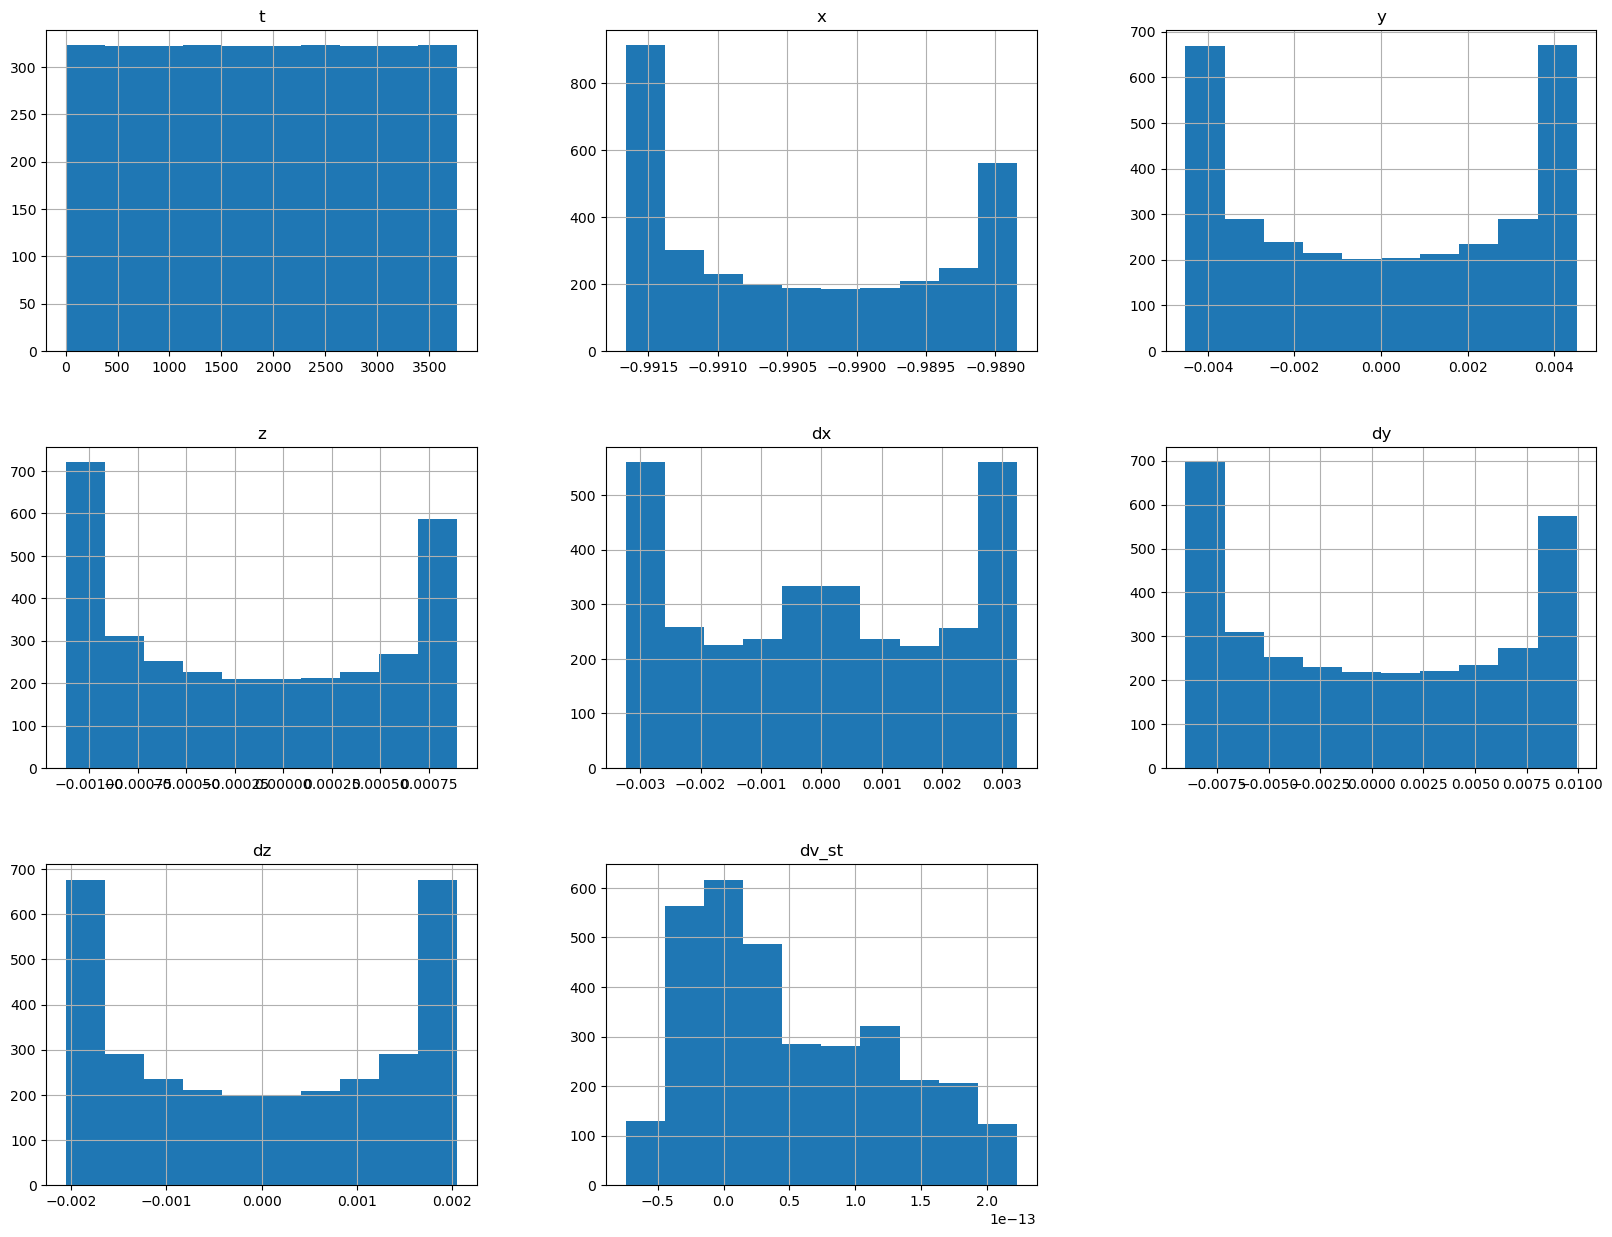

In [96]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Visualizing Data

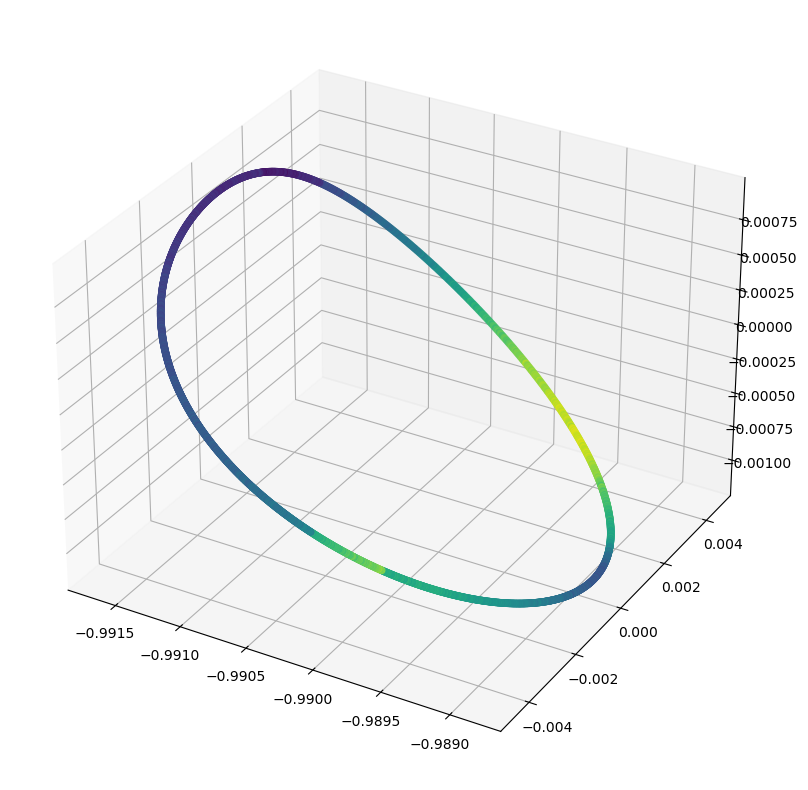

In [97]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [98]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
x        0.646894
dx       0.312646
y        0.271069
dz      -0.253164
dy      -0.706503
z       -0.712256
Name: dv_st, dtype: float64

array([[<Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='dx', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='x', ylabel='dx'>,
        <Axes: xlabel='dx', ylabel='dx'>,
        <Axes: xlabel='dv_st', ylabel='dx'>],
       [<Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='dx', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

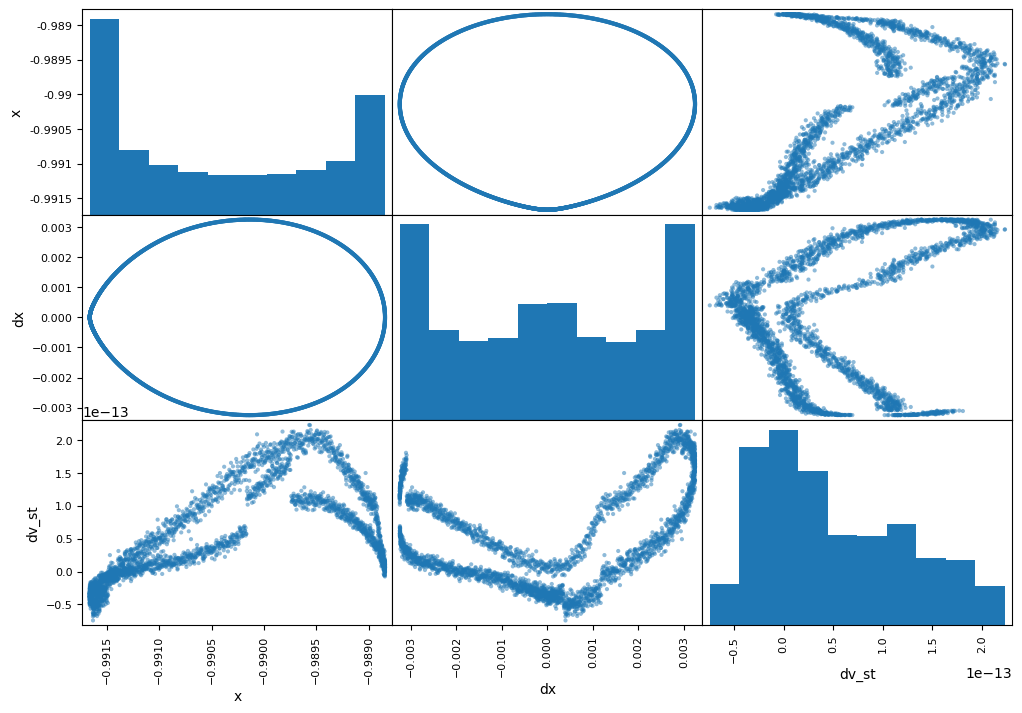

In [99]:
#attributes = ["angle", "x", "dx", "dv_st"]
attributes = ["x", "dx", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

## Create a Train/Test Set

In [100]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz
0,-0.988873,-0.000766,-0.001108,-0.000702,-0.008902,0.000304
1,-0.991569,-0.002555,0.000699,-0.000804,0.007992,0.001359
2,-0.990182,0.004321,-0.000465,0.003244,-0.002665,-0.001851
3,-0.989842,-0.003947,-0.000649,-0.003162,-0.004404,0.001650
4,-0.991632,0.001648,0.000819,0.000412,0.009151,-0.000904


In [101]:
## Create Train/Test/Validation Sets

In [102]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(1934, 6)
(645, 6)
(645, 6)


,x,y,z,dx,dy,dz
3164,-0.991614,0.001993,0.000781,0.000540,0.008779,-0.001082
2445,-0.989004,0.001756,-0.001050,0.001584,-0.008319,-0.000701
2377,-0.988901,0.001066,-0.001096,0.000973,-0.008776,-0.000423
2602,-0.989188,0.002516,-0.000968,0.002219,-0.007497,-0.001013
2033,-0.991620,0.001897,0.000793,0.000502,0.008890,-0.001033


In [103]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.01793419, 0.72039069, 0.94201145, 0.5832125 , 0.93925486,
        0.23621891],
       [0.94268845, 0.69418184, 0.03497819, 0.74395053, 0.03766827,
        0.32923086],
       [0.97928536, 0.61792348, 0.01253929, 0.64992401, 0.01355349,
        0.39677487],
       [0.87776198, 0.77828132, 0.07574182, 0.84189371, 0.08103618,
        0.25312272],
       [0.01593113, 0.70979108, 0.94769363, 0.57737031, 0.94512611,
        0.24816784]])

In [104]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [105]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [106]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.09262863161227672

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [107]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = tree_reg.predict(X_train_scaled)
tree_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

NOW THIS IS MUCH BETTER!!

In [108]:
#Let's try it out on 5 instances from the test set
some_data = X_test_scaled[10:20]
some_labels = y_test_scaled[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [0.4296028880866426, 0.6110928782408926, 0.2737118477190679, 0.277321956022317, 0.9465047587791271, 0.3715129635707253, 0.5536593370528389, 0.6133902198884149, 0.1470298654414178, 0.22021660649819494]
Labels: [array([0.4174598]), array([0.61634394]), array([0.3465704]), array([0.25533311]), array([0.87364621]), array([0.3702002]), array([0.51624549]), array([0.64850673]), array([0.14440433]), array([0.23104693])]


In [109]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_train_scaled)
forest_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.01292700862391492

## Polynomial Regression

In [110]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(X_train_scaled)
#print(X_train_scaled.head())
#print(maneuvers_pred_poly[0])

In [111]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, y_train_scaled)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.03743200057366793

## SVM Regression

In [112]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(X_train_scaled, y_train_scaled)
maneuvers_predictions = svm_poly_reg.predict(X_train_scaled)
svm_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0769106074926411

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Random Forest model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [113]:
from sklearn.model_selection import cross_val_score
#tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, X_train_scaled, y_train_scaled,
scoring="neg_root_mean_squared_error", cv=5)
forest_rmse_scores = -scores

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 

In [114]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(forest_rmse_scores)

Scores: [0.03371379 0.03446517 0.03704458 0.03290496 0.03492507]
Mean: 0.03461071410696086
Standard deviation: 0.0013969810899233787


## Evaluate Model on Test Set

In [115]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_test_scaled)
forest_mse = mean_squared_error(y_test_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.034080134555031616